In [9]:
import numpy as np
from packaging import version
import subprocess
import sys
# Following code required owing to the issue here https://github.com/h2oai/h2o-3/issues/16462 , once numpy 2 is supported the code can be removed
# Check if current NumPy is >= 2
if version.parse(np.__version__) >= version.parse("2.0"):
    print(f"Detected NumPy {np.__version__}, reinstalling < 2.0...")
    # Force reinstall only if needed
    subprocess.run([sys.executable, "-m", "pip", "install", "--force-reinstall", "--no-cache-dir", "numpy<2"])
    # Restart runtime (will interrupt execution)
    import os; os.kill(os.getpid(), 9)
else:
    print(f"NumPy {np.__version__} is already < 2.0. No action needed.")


NumPy 1.26.4 is already < 2.0. No action needed.


In [10]:
!nvidia-smi

Fri Aug  8 15:19:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
!pip install h2o
import os

In [12]:
def save_r2_metrics(model, data, save_path):
    """
    Save important classification metrics and plots to a file.

    Args:
        model (H2OModel): The regression model.
        save_path (str): The directory path where metrics and plots will be saved.

    Returns:
        None
    """
    # Create a directory to save the files
    os.makedirs(save_path, exist_ok=True)

    # Compute confusion matrix using the perf object
    perf = model.model_performance(data)
    r2 = model.r2()
    r2valid = model.r2(valid=True)
    r2test = perf.r2()
    mae = model.mae()
    maevalid = model.mae(valid=True)
    maetest = perf.mae()
    rmse = model.rmse()
    rmsevalid = model.rmse(valid=True)
    rmsetest = perf.rmse()

    with open(os.path.join(save_path, 'r2.txt'), 'w') as r2_file:
        r2_file.write(f"R2 : {r2}\n")
        r2_file.write(f"R2 Valid: {r2valid}\n")
        r2_file.write(f"R2 Test: {r2test}\n")
        r2_file.write(f"MAE : {mae}\n")
        r2_file.write(f"MAE Valid: {maevalid}\n")
        r2_file.write(f"MAE Test: {maetest}\n")
        r2_file.write(f"RMSE: {rmse}\n")
        r2_file.write(f"RMSE Valid: {rmsevalid}\n")
        r2_file.write(f"RMSE Test: {rmsetest}\n")

In [13]:
import h2o
from h2o.automl import H2OAutoML

In [14]:
import pandas as pd

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
h2o.init(max_mem_size = "45g")


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.28" 2025-07-15; OpenJDK Runtime Environment (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdaz4nr_r
  JVM stdout: /tmp/tmpdaz4nr_r/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdaz4nr_r/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,4 months and 11 days
H2O_cluster_name:,H2O_from_python_unknownUser_zu9r11
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,45 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [17]:
#cases2010to2018_h2o_orig = h2o.import_file('/content/drive/MyDrive/Law/automl_2010to2018_merged_partial_regr.csv')
cases2010to2018_h2o_orig = h2o.import_file('/content/drive/MyDrive/Law/Model2abbaselineData_2010to2018_merged_criminal_regr.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [18]:
print(len(cases2010to2018_h2o_orig))

22389955


In [19]:
cases2010to2018_h2o_orig.types

{'state_code': 'int',
 'female_defendant': 'int',
 'female_petitioner': 'enum',
 'female_adv_def': 'int',
 'female_adv_pet': 'int',
 'billable_ipc': 'enum',
 'female_judge_filing': 'enum',
 'female_judge_decision': 'enum',
 'judgediff': 'int',
 'pendency_decision_filing': 'int',
 'pendency_first_filing': 'int',
 'muslim_defendant': 'enum',
 'muslim_petitioner': 'enum',
 'muslim_adv_def': 'int',
 'muslim_adv_pet': 'int',
 'court_details': 'enum',
 'state_district': 'enum',
 'pendency_model_multiyear': 'enum',
 'filing_judge_tenure_at_filing': 'int',
 'decision_judge_tenure_at_decision': 'int',
 'act_s': 'enum',
 'section_s': 'int',
 'type_name_s': 'enum',
 'judge_position_s': 'enum',
 'number_sections_ipc_category': 'enum'}

In [20]:
#TBD to be converted to embeddings
#cases2010to2018_h2o['act_str'] = cases2010to2018_h2o['act_s'].ascharacter()
#cases2010to2018_h2o['section_str'] = cases2010to2018_h2o['section_s'].ascharacter()
#cases2010to2018_h2o['judge_position_s'] = cases2010to2018_h2o['judge_position_s'].ascharacter()

In [21]:
#Remove all columns not available at time of case filing

# List of columns to keep
columns_to_keep = cases2010to2018_h2o_orig.columns
columns_to_keep.remove("female_judge_decision")
columns_to_keep.remove("decision_judge_tenure_at_decision")
columns_to_keep.remove("pendency_first_filing")
columns_to_keep.remove("judgediff")
columns_to_keep.remove("pendency_model_multiyear")

#Drop columns related to advocate and religion
columns_to_keep.remove("muslim_defendant")
columns_to_keep.remove("muslim_petitioner")
columns_to_keep.remove("muslim_adv_def")
columns_to_keep.remove("muslim_adv_pet")
columns_to_keep.remove("female_adv_def")
columns_to_keep.remove("female_adv_pet")
columns_to_keep.remove("female_defendant")
columns_to_keep.remove("female_petitioner")
columns_to_keep.remove("female_judge_filing")

# Use the assign method to drop columns
cases2010to2018_h2o_orig = cases2010to2018_h2o_orig[columns_to_keep]

In [22]:
# Change types
cases2010to2018_h2o_orig['state_code'] = cases2010to2018_h2o_orig['state_code'].asfactor()
cases2010to2018_h2o_orig['section_s'] = cases2010to2018_h2o_orig['section_s'].asfactor()

In [23]:
cases2010to2018_h2o_orig.types

{'state_code': 'enum',
 'billable_ipc': 'enum',
 'pendency_decision_filing': 'int',
 'court_details': 'enum',
 'state_district': 'enum',
 'filing_judge_tenure_at_filing': 'int',
 'act_s': 'enum',
 'section_s': 'enum',
 'type_name_s': 'enum',
 'judge_position_s': 'enum',
 'number_sections_ipc_category': 'enum'}

In [24]:
cases2010to2018_h2o_orig = cases2010to2018_h2o_orig[((cases2010to2018_h2o_orig['pendency_decision_filing'] > 24))]

In [25]:
#Filter out undecided cases
cases2010to2018_h2o_orig = cases2010to2018_h2o_orig[((cases2010to2018_h2o_orig['pendency_decision_filing'] <= 100000))]

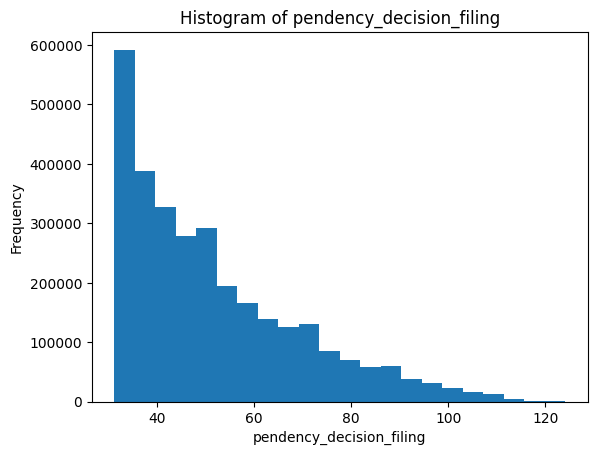

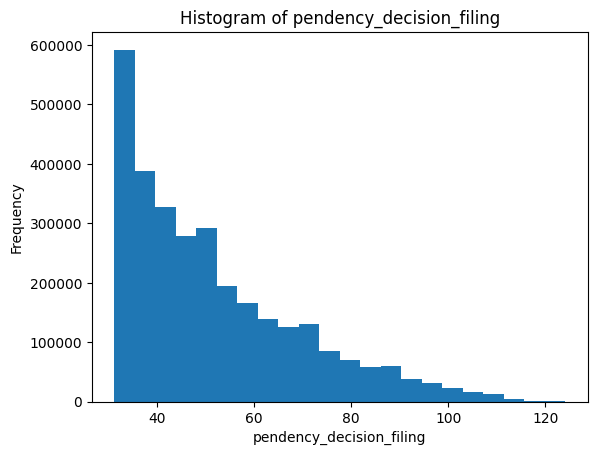

In [26]:
values_column = "pendency_decision_filing"

# Create a histogram in H2O
h2o_df = cases2010to2018_h2o_orig[values_column]
h2o_df.hist()
h2o_df.hist().figure().savefig("decision_histo_months.png")

In [27]:
# Convert the H2O DataFrame to a Pandas DataFrame
h2o_df_sum = cases2010to2018_h2o_orig[values_column].as_data_frame()

# Calculate summary statistics using Pandas
summary = h2o_df_sum.describe()

pd.set_option('display.float_format', '{:.2f}'.format)

# Print the summary statistics
print(summary)


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


       pendency_decision_filing
count                3035697.00
mean                      45.48
std                       17.93
min                       25.00
25%                       31.00
50%                       40.00
75%                       56.00
max                      122.00


In [28]:
print(len(cases2010to2018_h2o_orig))

3035697


In [29]:
cases2010to2018_train, cases2010to2018_test, cases2010to2018_valid = cases2010to2018_h2o_orig.split_frame(ratios=[.7, .15])

In [30]:
y = "pendency_decision_filing"
x = cases2010to2018_h2o_orig.columns
x.remove(y)

In [31]:
aml = H2OAutoML(max_models = 15, seed = 10, verbosity="info", nfolds=0, stopping_metric="RMSE", sort_metric="RMSE")


In [32]:
aml.train(x = x, y = y, training_frame = cases2010to2018_train, validation_frame=cases2010to2018_valid)

AutoML progress: |
15:20:37.960: Project: AutoML_1_20250808_152037
15:20:37.960: Cross-validation disabled by user: no fold column nor nfolds > 1.
15:20:37.961: Setting stopping tolerance adaptively based on the training frame: 0.001
15:20:37.961: Build control seed: 10
15:20:37.961: training frame: Frame key: AutoML_1_20250808_152037_training_py_19_sid_946c    cols: 11    rows: 2124929  chunks: 32    size: 33794044  checksum: 2974881053681603760
15:20:37.961: validation frame: Frame key: py_21_sid_946c    cols: 11    rows: 455355  chunks: 32    size: 8067791  checksum: 2971840394670375384
15:20:37.961: leaderboard frame: Frame key: py_21_sid_946c    cols: 11    rows: 455355  chunks: 32    size: 8067791  checksum: 2971840394670375384
15:20:37.961: blending frame: NULL
15:20:37.961: response column: pendency_decision_filing
15:20:37.961: fold column: null
15:20:37.962: weights column: null
15:20:37.978: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 1

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,70.0,70.0,8670930.0,0.0,15.0,12.642858,1.0,4221.0,2125.9714
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2025-08-08 15:31:46,0.010 sec,0.0,17.9223763,14.4219696,321.2115727,17.9164659,14.4182748,320.9997510
,2025-08-08 15:31:56,9.638 sec,5.0,16.0615620,12.9287944,257.9737751,16.1186752,12.9733806,259.8116908
,2025-08-08 15:32:02,16.108 sec,10.0,14.8360894,11.8982489,220.1095491,14.9681322,12.0019095,224.0449826
,2025-08-08 15:32:08,22.292 sec,15.0,14.2573416,11.3609361,203.2717885,14.4526562,11.5159203,208.8792727
,2025-08-08 15:32:15,28.680 sec,20.0,13.8695627,10.9808027,192.3647685,14.1347783,11.1923559,199.7919586
,2025-08-08 15:32:21,34.785 sec,25.0,13.6581089,10.7545726,186.5439396,13.9852029,11.0177253,195.5858997
,2025-08-08 15:32:26,40.333 sec,30.0,13.5337251,10.6144044,183.1617140,13.8947172,10.9069666,193.0631663
,2025-08-08 15:32:32,45.589 sec,35.0,13.4579914,10.5291374,181.1175320,13.8588248,10.8552799,192.0670245


In [33]:
aml.leaderboard

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_1_AutoML_1_20250808_152037,13.7891,190.138,10.7427,0.284694,190.138
XGBoost_1_AutoML_1_20250808_152037,13.8715,192.418,10.8786,0.287044,192.418
XGBoost_grid_1_AutoML_1_20250808_152037_model_1,13.9167,193.675,10.9321,0.28805,193.675
XGBoost_grid_1_AutoML_1_20250808_152037_model_2,13.9446,194.451,10.9653,0.288533,194.451
GBM_4_AutoML_1_20250808_152037,13.976,195.328,10.9471,0.28855,195.328
XGBoost_2_AutoML_1_20250808_152037,13.9842,195.558,11.0058,0.289401,195.558
DeepLearning_1_AutoML_1_20250808_152037,14.0299,196.839,11.0711,0.292203,196.839
GBM_3_AutoML_1_20250808_152037,14.1081,199.038,11.0723,0.291158,199.038
GBM_2_AutoML_1_20250808_152037,14.1789,201.04,11.1392,0.292494,201.04
DRF_1_AutoML_1_20250808_152037,14.226,202.379,11.2341,0.292002,202.379


In [34]:
lb = h2o.automl.get_leaderboard(aml)
lb_df = lb.as_data_frame()

# Now, you can save it to a CSV file
lb_df.to_csv('leaderboard.csv', index=False)

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [35]:
cases2010to2018_test.types

{'state_code': 'enum',
 'billable_ipc': 'enum',
 'pendency_decision_filing': 'int',
 'court_details': 'enum',
 'state_district': 'enum',
 'filing_judge_tenure_at_filing': 'int',
 'act_s': 'enum',
 'section_s': 'enum',
 'type_name_s': 'enum',
 'judge_position_s': 'enum',
 'number_sections_ipc_category': 'enum'}

In [36]:
!pip install --force-reinstall 'numpy<2'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 305.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [37]:
print(cases2010to2018_test)

  state_code  billable_ipc                 pendency_decision_filing    court_details    state_district    filing_judge_tenure_at_filing  act_s                         section_s  type_name_s     judge_position_s                   number_sections_ipc_category
           7  non-bailable                                       57           7_14_3              7_14                                3  The Indian Penal Code               328  NA              Chief Judicial Magistrate          5 to 10
           4  not applicable to section                          32          4_15_19              4_15                                0  The Indian Penal Code                56  NA              District And Sessions Court        two
          17  non-bailable                                       58          17_14_2             17_14                                8  The Indian Penal Code               381  cc              Civil Court                        four
          13  NA                      

In [38]:
explanations = aml.explain(cases2010to2018_test)

# Create a directory to save the plots
plots_dir = "/content/drive/MyDrive/Law/criminalregdelayed-used/explanation_plots"
os.makedirs(plots_dir, exist_ok=True)

def save_plots(plot_data, parent_key=""):
    for key, value in plot_data.items():
        if isinstance(value, h2o.plot._plot_result._MObject):
            # This is a plot object, save it
            plot_figure = value.figure()
            plot_filename = f"{plots_dir}/{parent_key}_{key}.png"
            plot_figure.savefig(plot_filename)
        elif isinstance(value, dict):
            # Recursively explore nested dictionaries
            save_plots(value, parent_key=f"{parent_key}_{key}")

# Call the function to save plots
save_plots(explanations)

Output hidden; open in https://colab.research.google.com to view.

In [39]:
save_path = "/content/drive/MyDrive/Law/criminalregdelayed-used/saved_models/"
os.makedirs(save_path, exist_ok=True)

output_directory = "/content/drive/MyDrive/Law/criminalregdelayed-used/performance"
os.makedirs(output_directory, exist_ok=True)

# Iterate through the models in the leaderboard and save
for index, row in lb_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)
    model.save_mojo(path=save_path)
    model_directory = os.path.join(output_directory, model_id)
    save_r2_metrics(model, cases2010to2018_test, model_directory)

In [ ]:
!cp /content/leaderboard.csv /content/drive/MyDrive/Law/criminalregdelayed-used/leaderboard.csv

In [41]:
!cp /content/decision_histo_months.png /content/drive/MyDrive/Law/criminalregdelayed-used/decision_histo_months.png

In [42]:
best_model = h2o.get_model(lb_df.iloc[0, 0])

In [43]:
# View the parameters for the XGBoost model selected above
best_model.params.keys()

print(best_model.params.keys())

# Inspect individual parameter values
print(best_model.params['ntrees'])
print(best_model.params['max_depth'])
print(best_model.params['min_rows'])
print(best_model.params['score_tree_interval'])
print(best_model.params['stopping_rounds'])
print(best_model.params['col_sample_rate_per_tree'])
print(best_model.params['min_split_improvement'])
print(best_model.params['sample_rate'])
print(best_model.params['stopping_metric'])
print(best_model.params['stopping_tolerance'])

dict_keys(['model_id', 'training_frame', 'validation_frame', 'nfolds', 'keep_cross_validation_models', 'keep_cross_validation_predictions', 'keep_cross_validation_fold_assignment', 'score_each_iteration', 'score_tree_interval', 'fold_assignment', 'fold_column', 'response_column', 'ignored_columns', 'ignore_const_cols', 'offset_column', 'weights_column', 'balance_classes', 'class_sampling_factors', 'max_after_balance_size', 'max_confusion_matrix_size', 'ntrees', 'max_depth', 'min_rows', 'nbins', 'nbins_top_level', 'nbins_cats', 'r2_stopping', 'stopping_rounds', 'stopping_metric', 'stopping_tolerance', 'max_runtime_secs', 'seed', 'build_tree_one_node', 'learn_rate', 'learn_rate_annealing', 'distribution', 'quantile_alpha', 'tweedie_power', 'huber_alpha', 'checkpoint', 'sample_rate', 'sample_rate_per_class', 'col_sample_rate', 'col_sample_rate_change_per_level', 'col_sample_rate_per_tree', 'min_split_improvement', 'histogram_type', 'max_abs_leafnode_pred', 'pred_noise_bandwidth', 'categor

In [44]:
import random

explanations_dir = "/content/drive/MyDrive/Law/criminalregdelayed-used/explanation_ind_plots"
os.makedirs(explanations_dir, exist_ok=True)


num_rows_to_explain = 10
random_indices = random.sample(range(cases2010to2018_test.nrow), num_rows_to_explain)
table_data = []

def save_plots_row(plot_data,plots_dir, parent_key=""):
    for key, value in plot_data.items():
        if isinstance(value, h2o.plot._plot_result._MObject):
            # This is a plot object, save it
            plot_figure = value.figure()
            plot_filename = f"{plots_dir}/{parent_key}_{key}.png"
            plot_figure.savefig(plot_filename)
        elif isinstance(value, dict):
            # Recursively explore nested dictionaries
            save_plots_row(value, plots_dir, parent_key=f"{parent_key}_{key}")

# Explain each of the selected rows and save the explanations
for row_index in random_indices:
    print(row_index)

    explanation = best_model.explain_row(cases2010to2018_test, row_index)
    # Retrieve the actual values and model predictions

    # Call the function to save plots
    save_plots_row(explanation,explanations_dir, row_index)
    actual_value = cases2010to2018_test[row_index, 'pendency_decision_filing']
    model_prediction = best_model.predict(cases2010to2018_test[row_index, :]).as_data_frame().iloc[0, 0]

    # Append the details to the table_data list
    table_data.append({'Serial Number': row_index + 1, 'Original': actual_value, 'Model Prediction': model_prediction})

# Create a DataFrame from the list
results_table = pd.DataFrame(table_data)

# Print or save the table as needed
print(results_table)
# Optionally save the table to a CSV file
table_filename = f"{explanations_dir}/randompredictions.csv"
results_table.to_csv(table_filename, index=False)

Output hidden; open in https://colab.research.google.com to view.